<a href="https://colab.research.google.com/github/c-w-m/btap/blob/master/ch03/Scraping_Extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[**Blueprints for Text Analysis Using Python**](https://github.com/blueprints-for-text-analytics-python/blueprints-text)  
Jens Albrecht, Sidharth Ramachandran, Christian Winkler

# Chapter 3:<div class='tocSkip'/>

# Scraping Websites and Extracting Data

## Remark<div class='tocSkip'/>

The code in this notebook differs slightly from the printed book. The Reuters website has changed significantly and is now obfuscated. For the illustractive examples we use the version from the Internet Archive. There are some utility functions which explain how to handle obfuscation though.

Moreover, several layout and formatting commands, like `figsize` to control figure size or subplot commands are removed in the book.

All of this is done to simplify the code in the book and put the focus on the important parts instead of formatting.

## Setup<div class='tocSkip'/>

Set directory locations. If working on Google Colab: copy files and install required libraries.

In [1]:
import sys, os
ON_COLAB = 'google.colab' in sys.modules

if ON_COLAB:
    GIT_ROOT = 'https://github.com/blueprints-for-text-analytics-python/blueprints-text/raw/master'
    os.system(f'wget {GIT_ROOT}/ch03/setup.py')

%run -i setup.py

You are working on a local system.
Files will be searched relative to "..".


## Load Python Settings<div class="tocSkip"/>

Common imports, defaults for formatting in Matplotlib, Pandas etc.

In [2]:
%run "$BASE_DIR/settings.py"

if ON_COLAB:
    %reload_ext autoreload
    %autoreload 2

%config InlineBackend.figure_format = 'png'

# Blueprint: download and interpret robots.txt

In [3]:
import urllib.robotparser
rp = urllib.robotparser.RobotFileParser()
rp.set_url("https://www.reuters.com/robots.txt")
rp.read()

In [4]:
rp.can_fetch("*", "https://www.reuters.com/sitemap.xml")

True

In [5]:
rp.can_fetch("*", "https://www.reuters.com/finance/stocks/option")

False

# Blueprint: finding URLs from sitemap.xml

In [6]:
# might need to install xmltodict
import xmltodict
import requests

sitemap = xmltodict.parse(requests.get('https://www.reuters.com/sitemap_news_index1.xml').text)

In [7]:
# just see some of the URLs
urls = [url["loc"] for url in sitemap["urlset"]["url"]]
print("\n".join(urls[0:3]))

https://www.reuters.com/article/us-people-dmx-memorial/rapper-dmx-memorial-service-to-be-livestreamed-from-brooklyns-barclays-center-idUSKBN2CB0GW
https://www.reuters.com/article/us-crypto-currency-bitcoin/bitcoin-falls-18-percent-to-50270-idUSKBN2CB0H4
https://www.reuters.com/article/crypto-currency-bitcoin/bitcoin-falls-18-percent-to-50270-idUSL4N2MH086


# Blueprint: finding URLs from RSS

Reuters removed its RSS feed after the book was published. We therefore use a saved copy from the Internet archive

In [8]:
# might need to install feedparser
import feedparser
feed = feedparser.parse('http://web.archive.org/web/20200613003232if_/http://feeds.reuters.com/Reuters/worldNews')

In [9]:
[(e.title, e.link) for e in feed.entries]

[('Mexico City to begin gradual exit from lockdown on Monday',
  'http://feeds.reuters.com/~r/Reuters/worldNews/~3/OQtkVdAqHos/mexico-city-to-begin-gradual-exit-from-lockdown-on-monday-idUSKBN23K00R'),
 ('Mexico reports record tally of 5,222 new coronavirus cases',
  'http://feeds.reuters.com/~r/Reuters/worldNews/~3/Rkz9j2G7lJU/mexico-reports-record-tally-of-5222-new-coronavirus-cases-idUSKBN23K00B'),
 ('Venezuela supreme court to swear in new electoral council leaders, government says',
  'http://feeds.reuters.com/~r/Reuters/worldNews/~3/cc3R5aq4Ksk/venezuela-supreme-court-to-swear-in-new-electoral-council-leaders-government-says-idUSKBN23J39T'),
 ("One-fifth of Britain's coronavirus patients were infected in hospitals: Telegraph",
  'http://feeds.reuters.com/~r/Reuters/worldNews/~3/1_7Wb0S_6-8/one-fifth-of-britains-coronavirus-patients-were-infected-in-hospitals-telegraph-idUSKBN23J382'),
 ('France to lift border controls for EU travellers on June 15',
  'http://feeds.reuters.com/~r/

In [10]:
[e.id for e in feed.entries]

['https://www.reuters.com/article/us-health-coronavirus-mexico-city/mexico-city-to-begin-gradual-exit-from-lockdown-on-monday-idUSKBN23K00R?feedType=RSS&feedName=worldNews',
 'https://www.reuters.com/article/us-health-coronavirus-mexico/mexico-reports-record-tally-of-5222-new-coronavirus-cases-idUSKBN23K00B?feedType=RSS&feedName=worldNews',
 'https://www.reuters.com/article/us-venezuela-politics/venezuela-supreme-court-to-swear-in-new-electoral-council-leaders-government-says-idUSKBN23J39T?feedType=RSS&feedName=worldNews',
 'https://www.reuters.com/article/us-health-coronavirus-britain-hospitals/one-fifth-of-britains-coronavirus-patients-were-infected-in-hospitals-telegraph-idUSKBN23J382?feedType=RSS&feedName=worldNews',
 'https://www.reuters.com/article/us-health-coronavirus-france-borders/france-to-lift-border-controls-for-eu-travellers-on-june-15-idUSKBN23J385?feedType=RSS&feedName=worldNews',
 'https://www.reuters.com/article/us-health-coronavirus-brazil/brazils-covid-19-deaths-sur

# Example: Downloading HTML pages with Python

In [11]:
%%time
s = requests.Session()
for url in urls[0:10]:
    # get the part after the last / in URL and use as filename
    file = url.split("/")[-1]
    
    r = s.get(url)
    with open(file, "w+b") as f:
        f.write(r.text.encode('utf-8'))

CPU times: user 84.5 ms, sys: 12.1 ms, total: 96.6 ms
Wall time: 1.4 s


In [12]:
with open("urls.txt", "w+b") as f:
    f.write("\n".join(urls).encode('utf-8'))

# Blueprint: Extraction with regular expressions

We first have to download a single article

In [13]:
url = 'https://www.reuters.com/article/us-health-vaping-marijuana-idUSKBN1WG4KT'

file = url.split("/")[-1] + ".html"

r = requests.get(url)

with open(file, "w+") as f:
    f.write(r.text)

In [14]:
import re
with open(file, "r") as f:
    html = f.read()
    g = re.search(r'<title>(.*)</title>', html, re.MULTILINE|re.DOTALL)
    if g:
        print(g.groups()[0])

Banned in Boston: Without vaping, medical marijuana patients must adapt | Reuters


# Using an HTML parser for extraction

Reuters changed its content structure after the book was published. Unfortunately, they *obfuscated* the content so that the methods in the book don't work without massive changes.

In this notebook, we stick to the text in the book and download the articles from the Internet archive which still has the old HTML structure.

In [15]:
WA_PREFIX = "http://web.archive.org/web/20200118131624/"
html = s.get(WA_PREFIX + url).text

In [16]:
from bs4 import BeautifulSoup
soup = BeautifulSoup(html, 'html.parser')
soup.select("h1.ArticleHeader_headline")

[<h1 class="ArticleHeader_headline">Banned in Boston: Without vaping, medical marijuana patients must adapt</h1>]

## Blueprint: extracting the title/headline

In [17]:
soup.h1

<h1 class="ArticleHeader_headline">Banned in Boston: Without vaping, medical marijuana patients must adapt</h1>

In [18]:
soup.h1.text

'Banned in Boston: Without vaping, medical marijuana patients must adapt'

In [19]:
soup.title.text

'\n                Banned in Boston: Without vaping, medical marijuana patients must adapt - Reuters'

In [20]:
soup.title.text.strip()

'Banned in Boston: Without vaping, medical marijuana patients must adapt - Reuters'

## Blueprint: extracting the article text

In [21]:
soup.select_one("div.StandardArticleBody_body").text

'BOSTON (Reuters) - In the first few days of the four-month ban on all vaping products in Massachusetts, Laura Lee Medeiros, a medical marijuana patient, began to worry.\xa0 FILE PHOTO: An employee puts down an eighth of an ounce marijuana after letting a customer smell it outside the Magnolia cannabis lounge in Oakland, California, U.S. April 20, 2018. REUTERS/Elijah NouvelageThe 32-year-old massage therapist has a diagnosis of post-traumatic stress disorder (PTSD) from childhood trauma. To temper her unpredictable panic attacks, she relied on a vape pen and cartridges filled with the marijuana derivatives THC and CBD from state dispensaries. There are other ways to get the desired effect from  marijuana, and patients have filled dispensaries across the state in recent days to ask about edible or smokeable forms. But Medeiros has come to depend on her battery-powered pen, and wondered how she would cope without her usual supply of cartridges.  “In the midst of something where I’m on t

## Blueprint: extracting image captions

In [22]:
soup.select("div.StandardArticleBody_body figure")

[<figure class="Image_zoom" style="padding-bottom:"><div class="LazyImage_container LazyImage_dark" style="background-image:none"><img aria-label="FILE PHOTO: An employee puts down an eighth of an ounce marijuana after letting a customer smell it outside the Magnolia cannabis lounge in Oakland, California, U.S. April 20, 2018. REUTERS/Elijah Nouvelage" src="//web.archive.org/web/20200118131624im_/https://s3.reutersmedia.net/resources/r/?m=02&amp;d=20191001&amp;t=2&amp;i=1435991144&amp;r=LYNXMPEF9039L&amp;w=20"/><div class="LazyImage_image LazyImage_fallback" style="background-image:url(//web.archive.org/web/20200118131624im_/https://s3.reutersmedia.net/resources/r/?m=02&amp;d=20191001&amp;t=2&amp;i=1435991144&amp;r=LYNXMPEF9039L&amp;w=20);background-position:center center;background-color:inherit"></div></div><div aria-label="Expand Image Slideshow" class="Image_expand-button" role="button" tabindex="0"><svg focusable="false" height="18px" version="1.1" viewbox="0 0 18 18" width="18px"

Variant

In [23]:
soup.select("div.StandardArticleBody_body figure img")

[<img aria-label="FILE PHOTO: An employee puts down an eighth of an ounce marijuana after letting a customer smell it outside the Magnolia cannabis lounge in Oakland, California, U.S. April 20, 2018. REUTERS/Elijah Nouvelage" src="//web.archive.org/web/20200118131624im_/https://s3.reutersmedia.net/resources/r/?m=02&amp;d=20191001&amp;t=2&amp;i=1435991144&amp;r=LYNXMPEF9039L&amp;w=20"/>,
 <img src="//web.archive.org/web/20200118131624im_/https://s3.reutersmedia.net/resources/r/?m=02&amp;d=20191001&amp;t=2&amp;i=1435991145&amp;r=LYNXMPEF9039M"/>]

In [24]:
soup.select("div.StandardArticleBody_body figcaption")

[<figcaption><div class="Image_caption"><span>FILE PHOTO: An employee puts down an eighth of an ounce marijuana after letting a customer smell it outside the Magnolia cannabis lounge in Oakland, California, U.S. April 20, 2018. REUTERS/Elijah Nouvelage</span></div></figcaption>,
 <figcaption class="Slideshow_caption">Slideshow<span class="Slideshow_count"> (2 Images)</span></figcaption>]

## Blueprint: extracting the URL

In [25]:
soup.find("link", {'rel': 'canonical'})['href']

'http://web.archive.org/web/20200118131624/https://www.reuters.com/article/us-health-vaping-marijuana-idUSKBN1WG4KT'

In [26]:
soup.select_one("link[rel=canonical]")['href']

'http://web.archive.org/web/20200118131624/https://www.reuters.com/article/us-health-vaping-marijuana-idUSKBN1WG4KT'

## Blueprint: extracting list information (authors)

In [27]:
soup.find("meta", {'name': 'Author'})['content']

'Jacqueline Tempera'

Variant

In [28]:
sel = "div.BylineBar_first-container.ArticleHeader_byline-bar div.BylineBar_byline span"
soup.select(sel)

[<span><a href="/web/20200118131624/https://www.reuters.com/journalists/jacqueline-tempera" target="_blank">Jacqueline Tempera</a>, </span>,
 <span><a href="/web/20200118131624/https://www.reuters.com/journalists/jonathan-allen" target="_blank">Jonathan Allen</a></span>]

In [29]:
[a.text for a in soup.select(sel)]

['Jacqueline Tempera, ', 'Jonathan Allen']

## Blueprint: Extracting text of links (section)


In [30]:
soup.select_one("div.ArticleHeader_channel a").text

'Health News'

## Blueprint: Extracting reading time

In [31]:
soup.select_one("p.BylineBar_reading-time").text

'6 Min Read'

## Blueprint: extracting attributes (id)

In [32]:
soup.select_one("div.StandardArticle_inner-container")['id']

'USKBN1WG4KT'

Alternative: URL

## Blueprint: Extracting Attribution

In [33]:
soup.select_one("p.Attribution_content").text

'Reporting Jacqueline Tempera in Brookline and Boston, Massachusetts, and Jonathan Allen in New York; Editing by Frank McGurty and Bill Berkrot'

## Blueprint: Extracting Timestamp

In [34]:
ptime = soup.find("meta", { 'property': "og:article:published_time"})['content']
print(ptime)

2019-10-01T19:23:16+0000


In [35]:
from dateutil import parser
parser.parse(ptime)

datetime.datetime(2019, 10, 1, 19, 23, 16, tzinfo=tzutc())

In [36]:
parser.parse(soup.find("meta", { 'property': "og:article:modified_time"})['content'])

datetime.datetime(2019, 10, 1, 19, 23, 16, tzinfo=tzutc())

# Blueprint: Spidering

In [37]:
import requests
from bs4 import BeautifulSoup
import os.path
from dateutil import parser

def download_archive_page(page):
    filename = "page-%06d.html" % page
    if not os.path.isfile(filename):
        url = "https://www.reuters.com/news/archive/" + \
              "?view=page&page=%d&pageSize=10" % page
        r = requests.get(url)
        with open(filename, "w+") as f:
            f.write(r.text)

def parse_archive_page(page_file):
    with open(page_file, "r") as f:
        html = f.read()
    soup = BeautifulSoup(html, 'html.parser')
    hrefs = ["https://www.reuters.com" + a['href'] 
               for a in soup.select("article.story div.story-content a")]
    return hrefs

def download_article(url):
    # check if article already there
    filename = url.split("/")[-1] + ".html"
    if not os.path.isfile(filename):
        r = requests.get(url)
        with open(filename, "w+") as f:
            f.write(r.text)

def parse_article(article_file):
    def find_obfuscated_class(soup, klass):
        try:
            return soup.find_all(lambda tag: tag.has_attr("class") and (klass in " ".join(tag["class"])))
        except Exception as err:
            # print('find_obfuscated_class Exception: {}'.format(err))
            return ''
    with open(article_file, "r") as f:
        html = f.read()
    r = {}
    soup = BeautifulSoup(html, 'html.parser')
    try:
        r['url'] = soup.find("link", {'rel': 'canonical'})['href']
        r['id'] = r['url'].split("-")[-1]
        r['headline'] = soup.h1.text
        r['section'] = find_obfuscated_class(soup, "ArticleHeader-channel")[0].text
        r['text'] = "\n".join([t.text for t in find_obfuscated_class(soup, "Paragraph-paragraph")])
        r['authors'] = find_obfuscated_class(soup, "Attribution-attribution")[0].text
        r['time'] = soup.find("meta", {'property': "og:article:published_time"})['content']
        return r
    except Exception as err:
        # print('Exception: {}'.format(err))
        return r

In [38]:
# download 10 pages of archive
for p in range(1, 10):
    download_archive_page(p)

In [39]:
# parse archive and add to article_urls
import glob

article_urls = []
for page_file in glob.glob("page-*.html"):
    article_urls += parse_archive_page(page_file)

In [40]:
# download articles
for url in article_urls:
    download_article(url)

In [41]:
# arrange in pandas DataFrame
import pandas as pd

df = pd.DataFrame()
for article_file in glob.glob("*-id???????????.html"):
    df = df.append(parse_article(article_file), ignore_index=True)
df['time'] = pd.to_datetime(df.time)

In [42]:
df

,headline,id,url,authors,section,text,time
0,AmericasU.S. vice president to speak with Mexican president on tree-planting proposal,24/,https://www.reuters.com/world/americas/us-vice-president-harris-speak-with-mexican-president-tree-planting-proposal-2021-04-24/,NaN,NaN,NaN,NaT
1,"United States‘Last Straw’: Americans confront racism, violence in Chauvin trial",21/,https://www.reuters.com/world/us/last-straw-americans-confront-racism-violence-chauvin-trial-2021-04-21/,NaN,NaN,NaN,NaT
2,United StatesConservative U.S. House Republicans to form 'America First' caucus,16/,https://www.reuters.com/world/us/us-house-republican-effort-form-america-first-caucus-raises-hackles-over-race-2021-04-16/,NaN,NaN,NaN,NaT
3,Sustainable BusinessWhite House taps conservationist to lead public lands bureau,23/,https://www.reuters.com/business/sustainable-business/white-house-taps-conservationist-lead-public-lands-bureau-2021-04-23/,NaN,NaN,NaN,NaT
4,Exclusive: Biden will push allies to act on China forced labor at G7 - adviser,idUSKBN2CB01E,https://www.reuters.com/article/us-usa-china-exclusive-idUSKBN2CB01E,Reporting by Andrea Shalal And Trevor Hunnicutt; Editing by Daniel Wallis,Business News,"WASHINGTON (Reuters) - The United States will urge its Group of Seven allies to increase pressure on China over the use of forced labor in its northwestern Xinjiang province, home to the Muslim Ui...",2021-04-24 00:48:17+00:00
...,...,...,...,...,...,...,...
110,Asia PacificTime running out for missing Indonesian submarine as U.S. joins search,23/,https://www.reuters.com/world/asia-pacific/desperate-hunt-missing-indonesian-submarine-oxygen-set-run-out-2021-04-23/,NaN,NaN,NaN,NaT
111,"WorldMore risks to pregnant women, their newborns from COVID-19 than known before - study",23/,https://www.reuters.com/world/more-risks-pregnant-women-their-newborns-covid-19-than-known-before-study-2021-04-23/,NaN,NaN,NaN,NaT
112,EuropeFrench PM calls killing of police worker an attack on nation,24/,https://www.reuters.com/world/europe/murder-police-employee-was-an-attack-france-pm-says-2021-04-24/,NaN,NaN,NaN,NaT
113,Biden's recognition of Armenian massacres as genocide is to honor victims - U.S. official,idUSKBN2CB0GG,https://www.reuters.com/article/us-turkey-usa-armenia-biden-idUSKBN2CB0GG,Reporting by Humeyra Pamuk; Editing by Grant McCool and Daniel Wallis,World News,WASHINGTON (Reuters) - U.S. President Joe Biden’s recognition that the 1915 massacres of Armenians in the final years of the Ottoman Empire constituted genocide aims to honor the victims and is no...,2021-04-24 16:28:21+00:00


In [43]:
df.sort_values("time")

,headline,id,url,authors,section,text,time
39,"Banned in Boston: Without vaping, medical marijuana patients must adapt",idUSKBN1WG4KT,https://www.reuters.com/article/us-health-vaping-marijuana-idUSKBN1WG4KT,"Reporting Jacqueline Tempera in Brookline and Boston, Massachusetts, and Jonathan Allen in New York; Editing by Frank McGurty and Bill Berkrot",Healthcare & Pharma,"BOSTON (Reuters) - In the first few days of the four-month ban on all vaping products in Massachusetts, Laura Lee Medeiros, a medical marijuana patient, began to worry.\nThe 32-year-old massage th...",2019-10-01 18:35:04+00:00
78,U.S. judge rejects ex-Trump lawyer Michael Cohen's bid to end sentence early,idUSKBN2C735N,https://www.reuters.com/article/us-usa-trump-cohen-idUSKBN2C735N,Reporting by Karen Freifeld and Jonathan Stempel in New York; Editing by Peter Cooney,U.S. News,"NEW YORK (Reuters) -A federal judge on Tuesday dismissed a petition by Michael Cohen, the onetime personal lawyer and fixer for former President Donald Trump, to release him from home confinement ...",2021-04-20 23:08:05+00:00
27,"U.S. seeing some Russian personnel withdrawing but still early, official says",idUSKBN2CA2DD,https://www.reuters.com/article/us-ukraine-crisis-russia-usa-idUSKBN2CA2DD,"Reporting by Phil Stewart and Idrees Ali, Editing by Franklin Paul",Europe News,WASHINGTON (Reuters) - The United States is seeing some Russian personnel withdrawing after a huge buildup near Ukraine but it is still early and Moscow’s announcement of its redeployment alone is...,2021-04-23 18:32:08+00:00
48,SE Asian nations say consensus reached on ending Myanmar crisis,idUSKBN2CA2NV,https://www.reuters.com/article/us-myanmar-politics-asean-idUSKBN2CA2NV,"Additional reporting by Nilufar Rizki, Fanny Potkin, Agustinus Beo Da Costa, Liz Lee, A. Ananthalakshmi, Aradhana Aravindan and Panu Wongcha-umWriting by Martin Petty and Raju Gopalakrishnan Editi...",APAC,"JAKARTA (Reuters) -Southeast Asian leaders said they had agreed on a plan with Myanmar’s junta chief on Saturday to end the crisis in the violence-hit nation, but he did not explicitly respond to ...",2021-04-23 22:05:48+00:00
80,Clashes on Gaza border as Ramadan violence flares in Jerusalem,idUSKBN2CA2O5,https://www.reuters.com/article/us-israel-palestinians-jerusalem-clashes-idUSKBN2CA2O5,"Additional reporting by Maayan Lubell in Jerusalem, Rami Ayyub in Tel Aviv, Nidal al-Mughrabi in Gaza and Ali Sawafta in Ramallah; Writing by Maayan Lubell and Rami Ayyub; Editing by Toby Chopra a...",World News,"JERUSALEM (Reuters) -Palestinian militants in the Gaza Strip fired dozens of rockets into Israel on Saturday drawing retaliatory air strikes, the Israeli military said, after nightly Ramadan clash...",2021-04-23 22:16:00+00:00
...,...,...,...,...,...,...,...
109,United StatesSexual assault prosecutions should be taken out U.S. military chain of command- panel,23/,https://www.reuters.com/world/us/sexual-assault-prosecutions-should-be-taken-out-us-military-chain-command-panel-2021-04-23/,NaN,NaN,NaN,NaT
110,Asia PacificTime running out for missing Indonesian submarine as U.S. joins search,23/,https://www.reuters.com/world/asia-pacific/desperate-hunt-missing-indonesian-submarine-oxygen-set-run-out-2021-04-23/,NaN,NaN,NaN,NaT
111,"WorldMore risks to pregnant women, their newborns from COVID-19 than known before - study",23/,https://www.reuters.com/world/more-risks-pregnant-women-their-newborns-covid-19-than-known-before-study-2021-04-23/,NaN,NaN,NaN,NaT
112,EuropeFrench PM calls killing of police worker an attack on nation,24/,https://www.reuters.com/world/europe/murder-police-employee-was-an-attack-france-pm-says-2021-04-24/,NaN,NaN,NaN,NaT


<AxesSubplot:xlabel='time'>

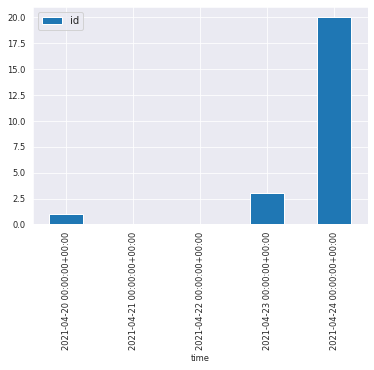

In [44]:
%matplotlib inline
df[df["time"]>='2020-01-01'].set_index("time").resample('D').agg({'id': 'count'}).plot.bar()

# Blueprint Density extraction

In [45]:
from readability import Document

doc = Document(html)
doc.title()

'Banned in Boston: Without vaping, medical marijuana patients must adapt - Reuters'

In [46]:
doc.short_title()

'Banned in Boston: Without vaping, medical marijuana patients must adapt'

In [47]:
doc.summary()

'<html><body><div><div class="StandardArticleBody_body"><p>BOSTON (Reuters) - In the first few days of the four-month ban on all vaping products in Massachusetts, Laura Lee Medeiros, a medical marijuana patient, began to worry.\xa0 </p><div class="PrimaryAsset_container"><div class="Image_container" tabindex="-1"><figure class="Image_zoom"></figure><figcaption><p class="Image_caption"><span>FILE PHOTO: An employee puts down an eighth of an ounce marijuana after letting a customer smell it outside the Magnolia cannabis lounge in Oakland, California, U.S. April 20, 2018. REUTERS/Elijah Nouvelage</span></p></figcaption></div></div><p>The 32-year-old massage therapist has a diagnosis of post-traumatic stress disorder (PTSD) from childhood trauma. To temper her unpredictable panic attacks, she relied on a vape pen and cartridges filled with the marijuana derivatives THC and CBD from state dispensaries. </p><p>There are other ways to get the desired effect from  marijuana, and patients have 

In [48]:
doc.url

In [49]:
density_soup = BeautifulSoup(doc.summary(), 'html.parser')
density_soup.body.text

'BOSTON (Reuters) - In the first few days of the four-month ban on all vaping products in Massachusetts, Laura Lee Medeiros, a medical marijuana patient, began to worry.\xa0 FILE PHOTO: An employee puts down an eighth of an ounce marijuana after letting a customer smell it outside the Magnolia cannabis lounge in Oakland, California, U.S. April 20, 2018. REUTERS/Elijah NouvelageThe 32-year-old massage therapist has a diagnosis of post-traumatic stress disorder (PTSD) from childhood trauma. To temper her unpredictable panic attacks, she relied on a vape pen and cartridges filled with the marijuana derivatives THC and CBD from state dispensaries. There are other ways to get the desired effect from  marijuana, and patients have filled dispensaries across the state in recent days to ask about edible or smokeable forms. But Medeiros has come to depend on her battery-powered pen, and wondered how she would cope without her usual supply of cartridges.  “In the midst of something where I’m on t

# Blueprint: Scrapy

Unfortunately, the code for `scrapy` cannot be changed easily. One more argument for using *up to date* separate libraries. In this version, it still collects the titles of the articles but not more.

In [50]:
# might need to install scrapy
import scrapy
import logging


class ReutersArchiveSpider(scrapy.Spider):
    name = 'reuters-archive'
    
    custom_settings = {
        'LOG_LEVEL': logging.WARNING,
        'FEED_FORMAT': 'json',
        'FEED_URI': 'reuters-archive.json'
    }
    
    start_urls = [
        'https://www.reuters.com/news/archive/',
    ]

    def parse(self, response):
        for article in response.css("article.story div.story-content a"):
            yield response.follow(article.css("a::attr(href)").extract_first(), self.parse_article)

        next_page_url = response.css('a.control-nav-next::attr(href)').extract_first()
        if (next_page_url is not None) & ('page=2' not in next_page_url):
            yield response.follow(next_page_url, self.parse)

    def parse_article(self, response):
        yield {
          'title': response.css('h1::text').extract_first().strip(),
        }

In [51]:
# this can be run only once from a Jupyter notebook due to Twisted
from scrapy.crawler import CrawlerProcess
process = CrawlerProcess()

process.crawl(ReutersArchiveSpider)
process.start()

2021-04-24 11:42:04 [scrapy.utils.log] INFO: Scrapy 2.5.0 started (bot: scrapybot)
2021-04-24 11:42:04 [scrapy.utils.log] INFO: Versions: lxml 4.6.3.0, libxml2 2.9.10, cssselect 1.1.0, parsel 1.6.0, w3lib 1.22.0, Twisted 21.2.0, Python 3.8.9 (default, Apr  3 2021, 01:02:10) - [GCC 5.4.0 20160609], pyOpenSSL 20.0.1 (OpenSSL 1.1.1k  25 Mar 2021), cryptography 3.4.7, Platform Linux-4.15.0-142-generic-x86_64-with-glibc2.17
2021-04-24 11:42:04 [scrapy.utils.log] DEBUG: Using reactor: twisted.internet.epollreactor.EPollReactor
2021-04-24 11:42:04 [scrapy.crawler] INFO: Overridden settings:
{'LOG_LEVEL': 30}


In [52]:
glob.glob("*.json")

['reuters-archive.json']

In [53]:
!cat 'reuters-archive.json'

[
{"title": "Biden's recognition of Armenian massacres as genocide is to honor victims - U.S. official"},
{"title": "In historic move, Biden says 1915 massacres of Armenians constitute genocide"},
{"title": "Fire extinguished on oil tanker off Syria after suspected drone attack"},
{"title": "Reactions after Biden announcement on Armenian genocide"},
{"title": "Factbox-The Armenian issue in the United States"},
{"title": "Explainer-Biden declares Armenian genocide. Here's what we know about 1915"},
{"title": "Rescuers find debris thought to be from missing Indonesian submarine"},
{"title": "Ahead of Geneva talks, Cypriots march for peace"},
{"title": "U.S. vice president to speak with Mexican president on tree-planting proposal"},
{"title": "Exclusive: Biden will push allies to act on China forced labor at G7 - adviser"},
{"title": "SE Asian nations say consensus reached on ending Myanmar crisis"},
{"title": "Caitlyn Jenner joins Republican fray seeking to unseat California governor"},
